In [1]:
####Topic sharing Duration time estimation####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

In [2]:
#多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

#切断ポアソン分布の乱数を生成する関数
def rtpois(mu, a, b, n):
    if a==0:
        FA = np.exp(-mu)
    else:
        FA = scipy.stats.poisson.cdf(a, mu)
    if b==np.inf:
        FB = np.repeat(1.0, n)
    else:
        FB = scipy.stats.poisson.cdf(b, mu)
    return np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")

#ポアソン分布の対数尤度
def Poisson_logpmf(mu, y, y_factorial):
    LL = y * np.log(mu) - mu - y_factorial
    return LL

#ガンマ分布の対数尤度
def Gamma_logpdf(kappa, mu, y, y_log):
    inv_Lambda = 1 / mu
    LL = kappa*np.log(inv_Lambda) - scipy.special.loggamma(kappa) + (kappa-1)*y_log -inv_Lambda*y
    return LL

In [3]:
####データの生成####
##データの定義
k1 = 5
k2 = 7
k_vec1 = np.repeat(1.0, k1)
k_vec2 = np.repeat(1.0, k2)
place = 50
hh = 25000
pt = rtpois(0.75, 0, np.inf, hh)
hhpt = np.sum(pt)
d_id = np.repeat(np.arange(hh), pt)
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [4]:
##訪問店舗を生成
#パラメータの定義
topic = 20
theta0 = np.random.dirichlet(np.repeat(5.0, topic), 1).reshape(-1)
phi0 = np.random.dirichlet(np.repeat(0.1, place), topic)
z0 = np.dot(np.random.multinomial(1, theta0, hh), np.arange(topic))[d_id, ]

#多項分布で店舗を選択
place_id1 = np.repeat(0, hhpt)
for i in range(hh):
    index = d_list[i]
    if pt[i]==1:
        place_id1[index] = np.dot(np.random.multinomial(1, phi0[z0[index], ].reshape(-1), pt[i]), np.arange(place))
    else:
        while True:
            get_place = rmnom(phi0[z0[index], ], pt[i], place, 1)[1]
            if np.max(np.sum(get_place, axis=0))==1:
                place_id1[index] = np.dot(get_place, np.arange(place))
                break
                
#インデックスを定義
place_list1 = [i for i in range(place)]
place_vec1 = [i for i in range(place)]
place_n1 = np.repeat(0, place)
for i in range(place):
    place_list1[i] = np.array(np.where(place_id1==i)[0], dtype="int")
    place_vec1[i] = np.repeat(1.0, place_list1[i].shape[0])
    place_n1[i] = place_list1[i].shape[0]

In [5]:
##訪問頻度を生成
#パーセンタイルを設定
normalized = (np.arange(k1) - np.mean(np.arange(k1))) / np.std(np.arange(k1)) 
percentile_value1 = 20*(np.exp((2.25*normalized)) / (1 + np.exp((2.25*normalized))))[::-1]
percentile_value2 = 100*np.exp(3.5*normalized) / (1 + np.exp(3.5*normalized))

#パラメータの生成
theta1 = np.random.dirichlet(percentile_value1, place)
beta1  = np.abs(np.random.normal(1.0, 0.2, k1*place)).reshape(place, k1)
gamma = np.percentile(np.random.gamma(1.5, 20, 10000), percentile_value2)
thetat1 = theta1.copy()
betat1 = beta1.copy(); gammat = gamma.copy()

#トピックと選択店舗から訪問頻度を生成
z1, Z1 = rmnom(theta1[place_id1, ], hhpt, k1, 1)
mu1 = np.dot(Z1*beta1[place_id1, ], k_vec1) * gamma[z1]
freq = rtpois(mu1, 0, np.inf, hhpt)
freq_factorial = scipy.special.gamma(freq + 1)
freq_lfactorial = scipy.special.loggamma(freq+1)
freq_log = np.log(freq)

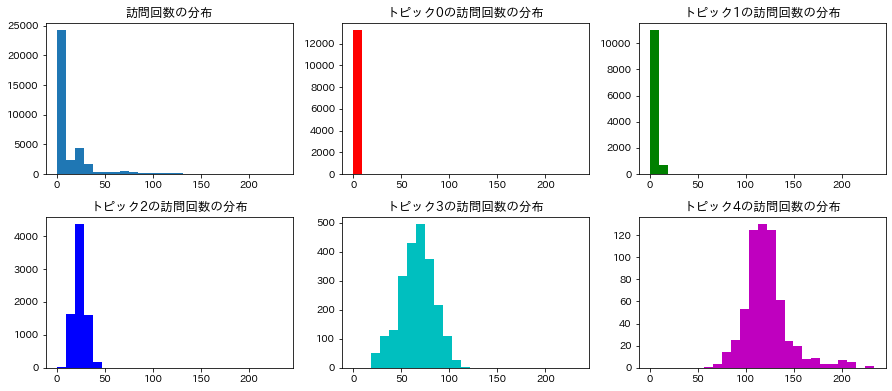

In [6]:
#訪問回数を可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.5, 8.0))
ax = fig.add_subplot(3, 3, 1)
plt.hist(freq, bins=25, range=(0, np.max(freq)))
plt.title("訪問回数の分布", fontsize=12.5)
for j in range(k1):
    ax = fig.add_subplot(3, 3, j+2)
    ax.hist(freq[z1==j],  bins=25, range=(0, np.max(freq)), color=colorlist[j])
    plt.title("トピック" + str(j) + "の訪問回数の分布", fontsize=12.5)
fig.tight_layout()
plt.show()

In [7]:
##訪問頻度の観測データを設定
#IDを定義
n = d_id.shape[0]
N = np.sum(freq)
exit_id = np.repeat(d_id, freq)
place_id2 = np.repeat(place_id1, freq)

#ユーザーインデックスを定義
exit_list = [i for i in range(hh)]
exit_vec = [i for i in range(hh)]
exit_n = np.repeat(0, hh)
for i in range(hh):
    exit_list[i] = np.array(np.where(exit_id==i)[0], dtype="int")
    exit_vec[i] = np.repeat(1.0, exit_list[i].shape[0])
    exit_n[i] = exit_list[i].shape[0]

#店舗インデックスを定義
place_list2 = [i for i in range(place)]
place_vec2 = [i for i in range(place)]
place_n2 = np.repeat(0, place)
for i in range(place):
    place_list2[i] = np.array(np.where(place_id2==i)[0], dtype="int")
    place_vec2[i] = np.repeat(1.0, place_list2[i].shape[0])
    place_n2[i] = place_list2[i].shape[0]

In [8]:
##滞在時間を生成
#パラメータを生成
#パーセンタイルを設定
normalized = (np.arange(k2) - np.mean(np.arange(k2))) / np.std(np.arange(k2)) 
percentile_value1 = (np.exp((1.0*normalized)) / (1 + np.exp((1.0*normalized))))[::-1]
percentile_value2 = 100*np.exp(3.0*normalized) / (1 + np.exp(3.0*normalized))
percentile_value3 = 100*np.exp(3.0*normalized) / (1 + np.exp(3.0*normalized))
percentile_value3[0:2] = np.array([5.0, 12.5])
percentile_value2[k2-1] = 99.9; percentile_value3[k2-1] = 99.5

#パラメータを生成
theta2 = np.random.dirichlet(percentile_value1, place)
beta2 = np.abs(np.random.normal(1.0, 0.1, k2*place)).reshape(place, k2)
beta3 = np.abs(np.random.normal(1.0, 0.1, k2*place)).reshape(place, k2)
kappa = np.percentile(np.random.gamma(1.5, 10, 10000), percentile_value2)
lkappa = np.log(kappa)
phi = np.percentile(np.random.gamma(0.75, 125, 10000), percentile_value3) / kappa
thetat2 = theta2.copy()
betat2 = beta2.copy(); betat3 = beta3.copy()
kappat = kappa.copy(); phit = phi.copy()

#トピックから滞在時間を生成
z2, Z2 = rmnom(theta2[place_id2, ], N, k2, 1)
mu2 = np.dot(Z2 * beta2[place_id2, ], k_vec2) * phi[z2, ]
Lambda = np.dot(Z2 * beta3[place_id2, ], k_vec2) * kappa[z2, ]
exit_time = np.random.gamma(Lambda, mu2, N)
y_log = np.log(exit_time)

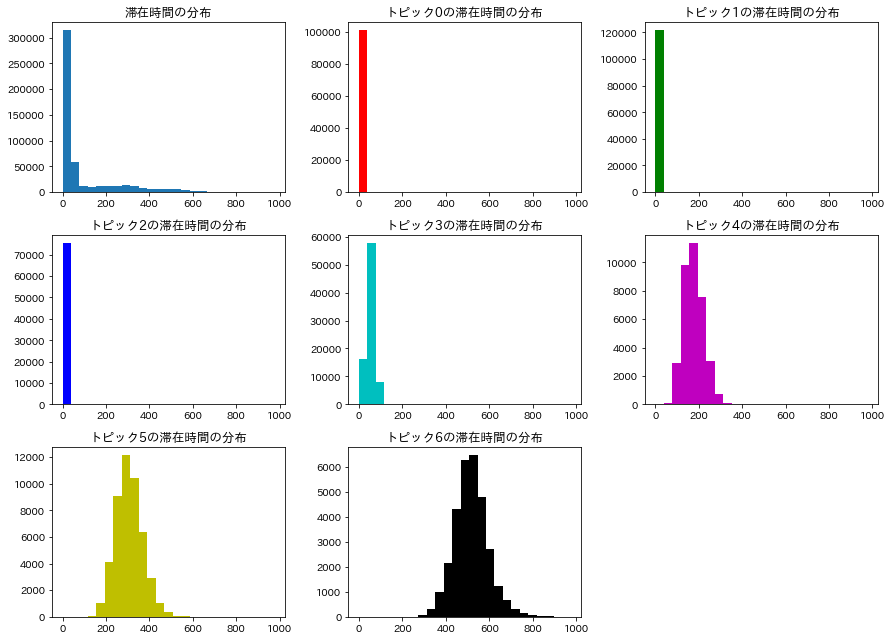

In [9]:
#滞在時間を可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "orangered"]
fig = plt.figure(figsize=(12.5, 9.0))
ax = fig.add_subplot(3, 3, 1)
plt.hist(exit_time, bins=25, range=(0, np.max(exit_time)))
plt.title("滞在時間の分布", fontsize=12.5)
for j in range(k2):
    ax = fig.add_subplot(3, 3, j+2)
    ax.hist(exit_time[z2==j],  bins=25, range=(0, np.max(exit_time)), color=colorlist[j])
    plt.title("トピック" + str(j) + "の滞在時間の分布", fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####Topic sharing Duration time estimation modelを推定####
##ガンマ分布のパラメータを推定するための関数
#ガンマ分布の確率密度関数
def Gamma_pdf(kappa, mu_vec, y_vec1):
    inv_Lambda = 1 / mu_vec
    Lho = (np.power(inv_Lambda, kappa) / scipy.special.gamma(kappa)) * np.power(y_vec1, kappa-1) * np.exp(-inv_Lambda*y_vec1)
    return Lho

##共通の形状パラメータをサンプリングするための関数
def Lho_kappa(lkappa, delta, tau, beta, mu, exit_time, y_log, index_z, place_id, k):
    #パラメータを定義
    kappa = np.exp(lkappad)
    inv_Lambda = 1 / mu
    lambda_y = inv_Lambda*exit_time
    lgamma = scipy.special.loggamma(beta*kappa)[place_id, ]
    new_kappa = (beta*kappa)[place_id, ]

    #対数事後分布の和
    Posterior = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j]
        Lho = np.sum(new_kappa[index, j]*np.log(inv_Lambda[index]) - lgamma[index, j] + 
                     (new_kappa[index, j]-1)*y_log[index] - lambda_y[index])
        Prior = -1/2 * np.power(lkappa[j] - delta[j], 2) / tau[j]
        Posterior[j] = Lho + Prior    
    return Posterior

#共通の形状パラメータの勾配ベクトル
def dll_kappa(lkappa, delta, tau, beta, mu, exit_time, place_id, index_z, k):
    #パラメータを定義
    kappa = np.exp(lkappa)
    inv_Lambda = 1 / mu
    digamma = scipy.special.digamma(kappa)

    #形状パラメータの勾配ベクトル
    gradient = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j]
        dll = np.sum(beta[place_id[index], j]*np.log(inv_Lambda[index]) - digamma[j] + np.log(exit_time[index]))
        dmv = -(lkappa[j] - delta[j]) / tau[j]
        gradient[j] = -(dll + dmv)
    return gradient

#共通の形状パラメータの数値微分
def diff_kappa(lkappa, delta, tau, beta, mu, exit_time, y_log, place_id, index_z, k):
    #パラメータを定義
    h = 1e-20
    kappa1 = np.exp(lkappa + h)
    kappa2 = np.exp(lkappa - h)
    lgamma1 = scipy.special.loggamma(beta*(kappa1))[place_id, ]
    lgamma2 = scipy.special.loggamma(beta*(kappa2))[place_id, ]
    new_kappa1 = (beta*kappa1)[place_id, ]
    new_kappa2 = (beta*kappa2)[place_id, ]
    inv_Lambda = 1 / mu
    lambda_y = inv_Lambda*exit_time

    #勾配ベクトルの和を定義
    gradient = np.repeat(0.0, k)
    for j in range(k):
        index = index_z[j]
        inv_lambda = inv_Lambda[index]
        lambda_log = np.log(inv_lambda)
        Lho1 = np.sum(new_kappa1[index, j]*lambda_log - lgamma1[index, j] + (new_kappa1[index, j]-1)*y_log[index] - lambda_y[index])
        Lho2 = np.sum(new_kappa2[index, j]*lambda_log - lgamma2[index, j] + (new_kappa2[index, j]-1)*y_log[index] - lambda_y[index])
        dll = (Lho1 - Lho2) / (2*h)
        dmv = -(lkappa[j] - delta[j]) / tau[j]
        gradient[j] = -(dll + dmv)
    return gradient

#共通の形状パラメータのリープフロッグ法を解く関数
def leapfrog_kappa(r, z1, D, e, L): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, delta1, tau1, beta3, mu, exit_time, y_log, place_id2, index_z2, k2) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, delta1, tau1, beta3, mu, exit_time, y_log, place_id2, index_z2, k2) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result


##店舗ごとの形状パラメータをサンプリングするための関数
#店舗ごとの対数事後分布の和
def Lho_beta(lbeta, delta, tau, kappa, Z, exit_time0, y_log0, inv_Lambda, lambda_log, place, place_id, place_list, k):
    #パラメータを定義
    beta = np.exp(lbeta)
    lgamma = Z * scipy.special.loggamma(beta*kappa)[place_id, ]
    new_kappa = Z * (beta*kappa)[place_id, ]
    lambda_y = inv_Lambda*exit_time0

    #対数事後分布の和
    Posterior = np.zeros((place, k))
    for i in range(place):
        index = place_list[i]
        Lho = np.sum(new_kappa[index, ]*lambda_log[index, ] - lgamma[index, ] +
                     (new_kappa[index, ]-Z[index, ])*y_log0[index, ] - lambda_y[index, ], axis=0)
        Prior = -1/2 * np.power(lbeta[i, ] - delta, 2) / tau
        Posterior[i, ] = Lho + Prior
    return Posterior 

#店舗ごとの形状パラメータの数値微分
def diff_beta(lbeta, delta, tau, kappa, Z, exit_time0, y_log0, inv_Lambda, lambda_log, place, place_id, place_list, k):
    #パラメータを定義
    h = 1e-20
    beta_h1 = np.exp(lbeta + h)
    beta_h2 = np.exp(lbeta - h)
    lgamma1 = Z * scipy.special.loggamma(beta_h1*kappa)[place_id, ]
    lgamma2 = Z * scipy.special.loggamma(beta_h2*kappa)[place_id, ]
    new_kappa1 = Z * (beta_h1*kappa)[place_id, ]
    new_kappa2 = Z * (beta_h2*kappa)[place_id, ]
    lambda_y = inv_Lambda*exit_time0

    #勾配ベクトルの和を定義
    gradient = np.zeros((place, k))
    for i in range(place):
        index = place_list[i]
        Lho1 = np.sum(new_kappa1[index, ]*lambda_log[index, ] - lgamma1[index, ] +
                      (new_kappa1[index, ]-Z[index, ])*y_log0[index, ] - lambda_y[index, ], axis=0)
        Lho2 = np.sum(new_kappa2[index, ]*lambda_log[index, ] - lgamma2[index, ] + 
                      (new_kappa2[index, ]-Z[index, ])*y_log0[index, ] - lambda_y[index, ], axis=0)
        dll = (Lho1 - Lho2) / (2*h)
        dmv = -(lbeta[i, ] - delta) / tau
        gradient[i, ] = -(dll + dmv)
    return gradient

#店舗ごとのリープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, delta2, tau2, kappa, Zi2, exit_time0, y_log0, inv_Lambda, lambda_log, place, place_id2, place_list2, k2) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, delta2, tau2, kappa, Zi2, exit_time0, y_log0, inv_Lambda, lambda_log, place, place_id2, place_list2, k2) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [11]:
##アルゴリズムの設定
#MCMCの設定
R = 1000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.0025
e2 = 0.0025
L1 = 3
L2 = 3

#事前分布の設定
alpha1 = 0.25
alpha2 = 0.1
delta1 =  np.arange(k2, step=0.7)[:k2]
delta2 = 0.0
tau1 = np.repeat(0.001, k2)
tau2 = 0.005
s11 = 0.1
v11 = 0.1
s12 = 1.0
v12 = 1.0
s21 = 0.1
v21 = 0.1
s22 = 100.0
v22 = 100.0

In [12]:
##パラメータの真値
#トピック分布の真値
theta1 = thetat1.copy()
theta2 = thetat2.copy()

#モデル}パラメータの真値
beta1 = betat1.copy()
beta2 = betat2.copy()
beta3 = betat3.copy()
lbeta = np.log(beta3)
gamma = gammat.copy()
phi = phit.copy()
kappa = kappat.copy()
lkappa = np.log(kappa)

#トピックの真値
Zi1 = Z1.copy()
Zi2 = Z2.copy()
z1 = np.dot(Zi1, np.arange(k1))
z2 = np.dot(Zi2, np.arange(k2))
index_z1 = [np.array(np.where(Zi1[:, j]==1)[0], dtype="int") for j in range(k1)]
index_z2 = [np.array(np.where(Zi2[:, j]==1)[0], dtype="int") for j in range(k2)]

#期待値の真値
mut1 = np.dot(Zi1 * beta1[place_id1, ], k_vec1) * gamma[z1]
mut2 = np.dot(Zi2 * beta2[place_id2, ], k_vec2) * phi[z2]
Lambdat = np.dot(Zi2 * beta3[place_id2, ], k_vec2) * kappa[z2, ]

In [13]:
##パラメータの初期値
#分位点を定義
normalized1 = (np.arange(k1) - np.mean(np.arange(k1))) / np.std(np.arange(k1)) 
normalized2 = (np.arange(k2) - np.mean(np.arange(k2))) / np.std(np.arange(k2)) 
percentile_value1 = 100 * (np.exp((2.75*normalized1)) / (1 + np.exp(2.75*normalized1)))
percentile_value2 = 100 * (np.exp(3.0*normalized2) / (1 + np.exp(3.0*normalized2)))

#トピック分布の初期値
theta1 = np.random.dirichlet(np.repeat(1.0, k1), place)
theta2 = np.random.dirichlet(np.repeat(1.0, k2), place)

#モデルパラメータの初期値
beta1 = np.abs(np.random.normal(1.0, 0.1, k1*place).reshape(place, k1))
beta2 = np.abs(np.random.normal(1.0, 0.01, k2*place).reshape(place, k2))
beta3 = np.abs(np.random.normal(1.0, 0.01, k2*place).reshape(place, k2))
lbeta = np.log(beta3)
gamma = np.percentile(freq, percentile_value1)
lkappa =  np.append(np.repeat(1.0, 3), np.repeat(3.0, k2-3))
lkappa =  np.arange(k2, step=0.5)[:k2]
kappa = np.exp(lkappa)
phi = np.percentile(exit_time, percentile_value2) / kappa

#トピックの初期値
z1, Zi1 = rmnom(theta1[place_id1, ], hhpt, k1, 1)
z2, Zi2 = rmnom(theta2[place_id2, ], N, k2, 1)
index_z1 = [np.array(np.where(Zi1[:, j]==1)[0], dtype="int") for j in range(k1)]
index_z2 = [np.array(np.where(Zi2[:, j]==1)[0], dtype="int") for j in range(k2)]

#期待値の初期値
mu1 = np.dot(Zi1 * beta1[place_id1, ], k_vec1) * gamma[z1]
mu2 = np.dot(Zi2 * beta2[place_id2, ], k_vec2) * phi[z2]
Lambda = np.dot(Zi2 * beta3[place_id2, ], k_vec2) * kappa[z2, ]

In [14]:
##パラメータの格納用配列
#モデルパラメータの格納用配列
THETA1 = np.zeros((place, k1, int(R/keep)))
THETA2 = np.zeros((place, k2, int(R/keep)))
BETA1 = np.zeros((place, k1, int(R/keep)))
BETA2 = np.zeros((place, k2, int(R/keep)))
BETA3 = np.zeros((place, k2, int(R/keep)))
GAMMA = np.zeros((int(R/keep), k1))
PHI = np.zeros((int(R/keep), k2))
KAPPA = np.zeros((int(R/keep), k2))

#トピックの格納用配列
SEG1 = np.zeros((int(R/keep), hhpt), dtype="int8")
SEG2 = np.zeros((int(R/keep), N), dtype="int8")

In [15]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst1 = np.sum(scipy.stats.poisson.logpmf(freq, np.mean(freq)))
LLst2 = np.sum(scipy.stats.gamma.logpdf(exit_time, 1.0, scale=np.mean(exit_time)))
print(np.round([LLst1, LLst2], 1))

#真値での対数尤度
mut1 = np.dot(Z1 * betat1[place_id1, ], k_vec1) * gammat[np.argmax(Z1, axis=1)]
mut2 = np.dot(Z2 * betat2[place_id2, ], k_vec2) * phit[np.argmax(Z2, axis=1)]
Lambdat = np.dot(Z2 * betat3[place_id2, ], k_vec2) * kappat[np.argmax(Z2, axis=1), ]
LLbest1 = np.sum(Poisson_logpmf(mut1, freq, freq_lfactorial))
LLbest2 = np.sum(Gamma_logpdf(Lambdat, mut2, exit_time, y_log))
print(np.round([LLbest1, LLbest2], 1))

[ -479435.6 -2702214.6]
[  -78835.6 -1698365.4]


In [16]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##トピックをサンプリング
    #モデルの事後分布を定義
    mu_deploy1 = beta1[place_id1, ] * gamma
    mu_deploy2 = beta2[place_id2, ] * phi
    lambda_deploy = beta3[place_id2, ] * kappa
    Lho1 = Poisson_logpmf(mu_deploy1, freq[:, np.newaxis], freq_lfactorial[:, np.newaxis])
    Lho2 = Gamma_logpdf(lambda_deploy, mu_deploy2, exit_time[:, np.newaxis], y_log[:, np.newaxis])
    Posterior1 = theta1[place_id1, ] * np.exp(Lho1 - np.max(Lho1, axis=1)[:, np.newaxis])
    Posterior2 = theta2[place_id2, ] * np.exp(Lho2 - np.max(Lho2, axis=1)[:, np.newaxis])

    #潜在変数の割当確率からトピックをサンプリング
    Prob1 = Posterior1 / np.dot(Posterior1, k_vec1)[:, np.newaxis]
    Prob2 = Posterior2 / np.dot(Posterior2, k_vec2)[:, np.newaxis]
    z1, Zi1 = rmnom(Prob1, hhpt, k1, 1)
    z2, Zi2 = rmnom(Prob2, N, k2, 1)

    #トピックのインデックスを定義
    index_z1 = [np.array(np.where(Zi1[:, j]==1)[0], dtype="int") for j in range(k1)]
    index_z2 = [np.array(np.where(Zi2[:, j]==1)[0], dtype="int") for j in range(k2)]


    ##トピック分布をサンプリング
    #訪問頻度のトピック分布をサンプリング
    for j in range(place):
        wsum = np.dot(Zi1[place_list1[j], ].T, place_vec1[j]) + alpha1
        theta1[j, ] = np.random.dirichlet(wsum, 1)

    #滞在時間のトピック分布をサンプリング
    for i in range(place):
        wsum = np.dot(Zi2[place_list2[i], ].T, place_vec2[i]) + alpha2
        theta2[i, ] = np.random.dirichlet(wsum, 1)


    ##訪問頻度のパラメータをサンプリング
    #共通のパラメータをサンプリング
    s = np.sum(Zi1 * freq[:, np.newaxis], axis=0) + s11
    v = np.sum(Zi1 * beta1[place_id1, ], axis=0) + v11
    gamma = np.random.gamma(s, 1/v, k1)

    #店舗ごとのパラメータをサンプリング
    s = np.zeros((place, k1))
    v = np.zeros((place, k1))
    for j in range(place):
        index = place_list1[j]
        s[j, ] = np.sum(Zi1[index, ] * freq[index, np.newaxis], axis=0) + s12
        v[j, ] = np.sum(Zi1[index, ] * gamma, axis=0) + v12
    beta1 = np.random.gamma(s, 1/v)


    ##滞在時間の尺度パラメータをサンプリング
    #共通のパラメータをサンプリング
    s = np.sum(Zi2 * exit_time[:, np.newaxis], axis=0) + s21
    v = np.sum(Zi2 * beta2[place_id2, ] * beta3[place_id2, ] * kappa, axis=0) + v21
    phi = np.random.gamma(s, 1/v, k2)

    #店舗ごとのパラメータのサンプリング
    s = np.zeros((place, k2))
    v = np.zeros((place, k2))
    for j in range(place):
        index = place_list2[j]
        s[j, ] = np.sum(Zi2[index, ] * exit_time[index, np.newaxis], axis=0) + s22
        v[j, ] = np.sum(Zi2[index, ] * beta3[place_id2[index], ] * kappa * phi, axis=0) + v22
    beta2 = np.random.gamma(s, 1/v)


    ##HMCで滞在時間の共通の形状パラメータをサンプリング
    #リープフロッグ法で新しいパラメータをサンプリング
    mu = np.dot(Zi2 * beta2[place_id2, ], k_vec2) * phi[z2]
    rold = np.random.normal(0, 1.0, k2)
    lkappad = lkappa.copy()
    res = leapfrog_kappa(rold, lkappad, diff_kappa, e1, L1)
    rnew = res[0]
    lkappan = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -Lho_kappa(lkappan, delta1, tau1, beta3, mu, exit_time, y_log, index_z2, place_id2, k2)
    Hold = -Lho_kappa(lkappad, delta1, tau1, beta3, mu, exit_time, y_log, index_z2, place_id2, k2)

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, k2)
    psi = np.exp(Hold - Hnew); psi[psi > 1.0] = 1.0
    accept_prob1 = psi.copy()
    flag = np.array(psi > rand, dtype="int")
    lkappa = flag*lkappan + (1-flag)*lkappad
    kappa = np.exp(lkappa)
    

    ##HMCで店舗ごとの形状パラメータをサンプリング
    #新しい変数を定義
    exit_time0 = Zi2 * exit_time[:, np.newaxis]
    y_log0 = Zi2 * y_log[:, np.newaxis]
    mu_deploy = beta2[place_id2, ] * phi
    inv_Lambda = Zi2 * (1 / mu_deploy) 
    lambda_log = Zi2 * np.log(1 / mu_deploy)

    #リープフロッグ法で新しいパラメータをサンプリング
    rold = np.random.normal(0, 1.0, k2*place).reshape(place, k2)
    lbetad = lbeta.copy()
    res = leapfrog_beta(rold, lbetad, diff_beta, e2, L2)
    rnew = res[0]
    lbetan = res[1]

    #移動前と移動後のハミルトニアン
    Lho_new = Lho_beta(lbetan, delta2, tau2, kappa, Zi2, exit_time0, y_log0, inv_Lambda, lambda_log, place, place_id2, place_list2, k2)
    Lho_old = Lho_beta(lbetad, delta2, tau2, kappa, Zi2, exit_time0, y_log0, inv_Lambda, lambda_log, place, place_id2, place_list2, k2)
    Hnew = -Lho_new + np.power(rnew, 2)/2
    Hold = -Lho_old + np.power(rold, 2)/2

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, k2*place).reshape(place, k2)
    psi = np.exp(Hold - Hnew); psi[psi > 1.0] = 1.0
    accept_prob2 = psi.copy()
    flag = np.array(psi > rand, dtype="int")
    lbeta = flag*lbetan + (1-flag)*lbetad
    beta3 = np.exp(lbeta)
    
    
    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA1[:, :, mkeep] = theta1
        THETA2[:, :, mkeep] = theta2
        BETA1[:, :, mkeep] = beta1
        BETA2[:, :, mkeep] = beta2
        BETA3[:, :, mkeep] = beta3
        GAMMA[mkeep, ] = gamma
        PHI[mkeep, ] = phi
        KAPPA[mkeep, ] = kappa
        SEG1[mkeep, ] = z1
        SEG2[mkeep, ] = z2

    #対数尤度の更新とサンプリング結果の表示
    if rp%disp==0:  
        #期待値の更新
        mu1 = np.dot(Zi1 * beta1[place_id1, ], k_vec1) * gamma[z1]
        mu2 = np.dot(Zi2 * beta2[place_id2, ], k_vec2) * phi[z2]
        Lambda = np.dot(Zi2 * beta3[place_id2, ], k_vec2) * kappa[z2, ]

        #対数尤度の更新
        LL1 = np.sum(Poisson_logpmf(mu1, freq, freq_lfactorial))
        LL2 = np.sum(Gamma_logpdf(Lambda, mu2, exit_time, y_log))

        #サンプリング結果の表示
        print(rp)
        print(np.round(accept_prob1, 3))
        print(np.round(np.mean(accept_prob2, axis=0), 3))
        print(np.round(np.vstack((np.mean(beta1*gamma, axis=0), 
                                 np.mean(betat1*gamma, axis=0))), 1))
        print(np.round(np.vstack((np.mean((beta2*phi) * (beta3*kappa), axis=0), 
                                  np.mean((betat2*phit) * (betat3*kappat), axis=0))), 1))
        print(np.round(np.vstack((np.mean(beta3*kappa, axis=0), 
                                  np.mean(betat3*kappat, axis=0))), 1))
        print(np.round([LL1, LLst1, LLbest1], 1))
        print(np.round([LL2, LLst2, LLbest2], 1))

0
[0.9 1.  1.  1.  1.  1.  1. ]
[0.881 0.824 0.771 0.64  0.747 0.792 0.885]
[[ 1.6  1.6  5.  25.  87.7]
 [ 1.8  1.7  5.  24.5 88.6]]
[[0.000e+00 4.000e-01 2.900e+00 1.560e+01 1.396e+02 3.718e+02 4.905e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 1.   1.7  2.7  4.6  7.5 12.5 20.8]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -87956.3 -479435.6  -78835.6]
[-1746142.6 -2702214.6 -1698365.4]
10
[0.999 1.    1.    1.    1.    1.    1.   ]
[0.909 0.904 0.668 0.727 0.664 0.736 0.859]
[[ 2.   2.2  5.7 24.9 90.5]
 [ 2.2  2.2  5.6 24.3 87.3]]
[[  0.    0.6   4.6  20.7 125.2 327.8 513.3]
 [  2.2   7.4  12.1  56.6 168.8 312.4 566.1]]
[[ 1.   1.8  3.   5.1  9.1 15.8 28.1]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -84507.7 -479435.6  -78835.6]
[-1640970.1 -2702214.6 -1698365.4]
20
[1.    1.    0.471 1.    1.    1.    1.   ]
[0.939 0.881 0.775 0.694 0.636 0.691 0.78 ]
[[ 2.3  2.5  6.  25.1 90.4]
 [ 2.4  2.3  5.7 24.2 87.2]]
[[1.000e-01 8.000e-01 5.200e+00 2.260e+01 1.1

190
[1.    1.    1.    0.956 1.    1.    0.991]
[0.819 0.911 0.807 0.805 0.735 0.714 0.715]
[[ 2.6  2.9  6.6 25.  90.6]
 [ 3.2  2.8  6.2 25.7 87.3]]
[[2.000e-01 2.000e+00 8.300e+00 3.040e+01 1.132e+02 2.714e+02 4.921e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.9  1.9  3.8  7.4 15.4 31.3 61.9]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -84384.6 -479435.6  -78835.6]
[-1593110.8 -2702214.6 -1698365.4]
200
[0.934 0.978 1.    1.    0.974 1.    0.973]
[0.824 0.875 0.838 0.771 0.731 0.797 0.77 ]
[[ 3.   2.8  6.5 24.9 89.8]
 [ 3.2  2.8  6.5 25.9 87.8]]
[[2.000e-01 2.100e+00 8.200e+00 3.120e+01 1.124e+02 2.723e+02 4.902e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.9  1.9  3.8  7.5 15.5 31.5 61.9]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -84330.7 -479435.6  -78835.6]
[-1594185.6 -2702214.6 -1698365.4]
210
[0.873 1.    0.946 1.    1.    0.986 1.   ]
[0.852 0.803 0.822 0.822 0.773 0.742 0.649]
[[ 2.8  2.6  6.5 25.  90.3]


380
[0.998 1.    0.937 1.    0.92  0.871 0.788]
[0.85  0.84  0.822 0.755 0.828 0.694 0.764]
[[ 3.4  3.2  6.8 25.2 90.4]
 [ 3.   2.9  6.7 24.8 91.1]]
[[3.000e-01 2.500e+00 9.000e+00 3.390e+01 1.102e+02 2.721e+02 4.821e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.9  2.   3.7  7.8 15.2 30.1 62.7]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -84056.7 -479435.6  -78835.6]
[-1604085.8 -2702214.6 -1698365.4]
390
[0.92  0.795 0.965 0.764 0.949 1.    1.   ]
[0.856 0.887 0.74  0.872 0.788 0.72  0.704]
[[ 3.1  3.6  6.6 24.9 90.4]
 [ 3.   2.9  6.5 25.  91.9]]
[[4.000e-01 2.600e+00 9.300e+00 3.420e+01 1.119e+02 2.719e+02 4.886e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.9  2.   3.9  8.1 15.5 30.4 64.4]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -84162.8 -479435.6  -78835.6]
[-1602689.5 -2702214.6 -1698365.4]
400
[0.809 1.    1.    0.264 0.954 1.    0.915]
[0.849 0.849 0.821 0.806 0.789 0.684 0.684]
[[ 2.9  3.3  6.8 25.  90.4]


570
[1.    0.871 0.794 0.971 1.    1.    0.779]
[0.889 0.785 0.747 0.793 0.717 0.75  0.669]
[[ 2.9  4.1  7.  26.6 90.3]
 [ 3.4  3.5  6.8 24.8 93.3]]
[[5.000e-01 3.000e+00 9.900e+00 3.700e+01 1.115e+02 2.689e+02 4.942e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.8  2.   4.   8.1 15.7 30.9 65.9]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -83641.7 -479435.6  -78835.6]
[-1607664.  -2702214.6 -1698365.4]
580
[1.    0.971 0.859 0.998 1.    0.996 0.679]
[0.877 0.926 0.734 0.854 0.737 0.685 0.82 ]
[[ 3.1  4.6  6.5 26.6 91.6]
 [ 3.2  3.5  6.5 25.  92.9]]
[[5.000e-01 3.000e+00 9.900e+00 3.740e+01 1.114e+02 2.697e+02 4.897e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.8  2.   4.   8.2 15.8 30.8 67. ]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -83755.4 -479435.6  -78835.6]
[-1608213.2 -2702214.6 -1698365.4]
590
[0.944 1.    0.937 1.    1.    1.    1.   ]
[0.9   0.899 0.841 0.8   0.701 0.667 0.684]
[[ 2.9  5.   6.8 26.8 90.5]


760
[0.984 0.93  0.959 1.    1.    1.    0.735]
[0.877 0.815 0.777 0.868 0.722 0.72  0.696]
[[ 3.6  5.3  6.6 27.6 91.2]
 [ 3.1  3.9  5.8 27.6 86.6]]
[[5.000e-01 3.300e+00 1.030e+01 4.020e+01 1.126e+02 2.720e+02 4.774e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.8  2.   3.9  8.  15.5 31.1 62.9]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -83142.9 -479435.6  -78835.6]
[-1618444.  -2702214.6 -1698365.4]
770
[0.98  1.    0.915 1.    0.445 1.    1.   ]
[0.872 0.873 0.8   0.864 0.731 0.822 0.759]
[[ 3.4  4.9  6.4 27.8 90.7]
 [ 3.3  3.9  5.9 26.9 86.6]]
[[5.000e-01 3.400e+00 1.040e+01 4.040e+01 1.129e+02 2.709e+02 4.898e+02]
 [2.200e+00 7.400e+00 1.210e+01 5.660e+01 1.688e+02 3.124e+02 5.661e+02]]
[[ 0.9  2.   4.   8.2 15.1 30.2 64.6]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -83334.4 -479435.6  -78835.6]
[-1618378.7 -2702214.6 -1698365.4]
780
[1.    0.72  1.    0.992 1.    1.    1.   ]
[0.859 0.78  0.807 0.78  0.785 0.815 0.706]
[[ 3.6  5.2  6.5 27.8 90.6]


970
[0.971 0.787 0.895 1.    0.658 0.937 1.   ]
[0.846 0.836 0.74  0.91  0.791 0.732 0.767]
[[ 3.4  6.3  7.  29.5 91.1]
 [ 3.5  4.5  5.9 24.6 84. ]]
[[  0.6   3.3  10.4  43.3 115.9 268.2 490.5]
 [  2.2   7.4  12.1  56.6 168.8 312.4 566.1]]
[[ 0.8  2.   3.9  8.4 15.7 30.9 63.8]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -83045.7 -479435.6  -78835.6]
[-1622531.1 -2702214.6 -1698365.4]
980
[0.984 1.    0.86  1.    0.989 0.892 1.   ]
[0.894 0.848 0.796 0.817 0.79  0.744 0.687]
[[ 3.6  6.1  7.6 29.7 92.2]
 [ 3.4  4.6  6.1 24.5 82.8]]
[[  0.6   3.4  10.6  42.4 117.8 271.7 494.1]
 [  2.2   7.4  12.1  56.6 168.8 312.4 566.1]]
[[ 0.8  2.   4.   8.4 16.3 30.6 63.7]
 [ 0.6  1.7  4.6 12.  24.7 39.1 78.4]]
[ -82926.3 -479435.6  -78835.6]
[-1621289.4 -2702214.6 -1698365.4]
990
[1.    1.    0.777 0.866 1.    0.86  1.   ]
[0.912 0.885 0.868 0.849 0.722 0.738 0.773]
[[ 3.9  5.9  7.2 29.7 91.8]
 [ 3.4  4.7  6.2 24.5 82.8]]
[[  0.6   3.4  10.6  44.3 118.9 270.4 491.7]
 [  2.2   7.4  12.1  56.6 168.8 312.4 